# Keywords extraction from papers 


This notebook shows a simple strategy to collect a reasonable set of keywords from a collection of documents. 

As an example, keywords will be extracted from NeurIPS corpus of abstracts. 

In [1]:
import os
import json
from collections import defaultdict

from tqdm.notebook import tqdm

from papeles.paper.neurips import get_key


In [2]:
NEURIPS_ANALYSIS_DATA_PATH = '/var/data/neurips_analysis'

metadata_path = os.path.join(NEURIPS_ANALYSIS_DATA_PATH, 'files_metadata/')
metadata = {}
for filename in tqdm(os.listdir(metadata_path), 'loading metadata'):
    with open(os.path.join(metadata_path, filename), 'r') as f: # open in readonly mode
        for line in f.readlines():
            data = json.loads(line)
            metadata[get_key(data['pdf_name'])] = data


In [3]:
from papeles.utils import text as text_utils
from papeles.utils import keywords


## Corpus generation 

To extract all keywords, first let's generate a two datasets with n-grams, one for n=2 and another one for n=3. 

The goal is to extract keywords from these versions of the data. 

In [4]:
text_list_n2_year = defaultdict(list)
text_list_n3_year = defaultdict(list)
for file, data in tqdm(metadata.items()):
    text_list_n2_year[data['year']].append(text_utils.generate_ngram_text(data['abstract'], 2))
    text_list_n3_year[data['year']].append(text_utils.generate_ngram_text(data['abstract'], 3))


## Keywords extraction 

Now that the datasets are generated, let's extract keywords using a very simple TF-IDF model implemented in the `papeles` python package. 

In [5]:
# Note that keywords were extracted per year (computing IDF over that particular year documents)

year_keywords_counter_n2 = {} 
year_keywords_counter_n3 = {} 
for year in tqdm(range(2009, 2020), 'year'):    
    year_keywords_counter_n2[year] = keywords.get_keywords(text_list_n2_year[year])
    year_keywords_counter_n3[year] = keywords.get_keywords(text_list_n3_year[year])    


In [6]:
with open('year_keywords_counter_n2.json', 'w') as f:
    json.dump(year_keywords_counter_n2, f)

with open('year_keywords_counter_n3.json', 'w') as f:
    json.dump(year_keywords_counter_n3, f)


In [7]:
for year, keywords in year_keywords_counter_n3.items():
    print(year)
    for keyword in sorted(keywords.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(keyword)

2009
('high_dimensional_data', 2)
('goal_central_study', 1)
('central_study_hierarchical', 1)
('study_hierarchical_models', 1)
('hierarchical_models_object', 1)
('models_object_recognition', 1)
('object_recognition_--', 1)
('recognition_--_visual', 1)
('--_visual_cortex', 1)
('visual_cortex_--', 1)
2010
('policy_gradient_methods', 2)
('empirical_risk_minimization', 2)
('paper_introduces_monte-carlo', 1)
('introduces_monte-carlo_algorithm', 1)
('monte-carlo_algorithm_online', 1)
('algorithm_online_planning', 1)
('online_planning_large', 1)
('planning_large_pomdps', 1)
('large_pomdps_algorithm', 1)
('pomdps_algorithm_combines', 1)
2011
('multiple_kernel_learning', 2)
('explicit_classes_probability', 1)
('classes_probability_distributions', 1)
('probability_distributions_learned', 1)
('distributions_learned_restricted', 1)
('learned_restricted_boltzmann', 1)
('boltzmann_machines_rbms', 1)
('machines_rbms_depending', 1)
('rbms_depending_number', 1)
('depending_number_units', 1)
2012
('spar

In [8]:
from collections import Counter 


exclude_keywords = {'machine_learning', 'data_sets', 
                    'learning_algorithms', 'proposed_algorithm',
                    'wide_range', 'existing_methods', 'large_number', 
                    'proposed_method', 'learning_algorithm',
                    'abstract_missing', 'learning_problem', 'small_number', 
                    'state_art', 'model_achieves_error'}

map_keywords = {
    'neural_network': 'neural_networks',
    'loss_functions': 'loss_function',
    'lower_bounds': 'lower_bound'
    
}

def get_year_keywords(year_keywords, ngrams, metadata, years):
    """
    Auxiliary method to count keywords per document per year. 
    
    Very particular for this analysis, so I decided not to add it to the papeles package. 
    """
    keywords_year_counter = {}
    for year in tqdm(years):
        keywords_counter = Counter()
        _year_keywords = {map_keywords.get(x[0], x[0]) for x in year_keywords[year].items() if x[0] not in exclude_keywords}
        for k, v in metadata.items():
            if v['year'] == year:
                gen_text = set(text_utils.generate_ngram_text(v['abstract'], ngrams))
                intersection = gen_text.intersection(_year_keywords)
                keywords_counter.update(list(intersection))
        keywords_year_counter[year] = keywords_counter
    return keywords_year_counter

keywords_year_counter_n2 = get_year_keywords(year_keywords_counter_n2, 2, metadata, range(2009, 2020))        
keywords_year_counter_n3 = get_year_keywords(year_keywords_counter_n3, 3, metadata, range(2009, 2020))


In [9]:
final_keywords_n3 = defaultdict(int)
for year, freqs in keywords_year_counter_n3.items():
    for keyword in [x for x in sorted(freqs.items(), key=lambda x: x[1], reverse=True) if x[1] > 2]:
        final_keywords_n3[keyword[0]] += keyword[1]
len(final_keywords_n3)

123

In [10]:
sorted(final_keywords_n3.items(), key=lambda x: x[1], reverse=True)

[('deep_neural_networks', 101),
 ('stochastic_gradient_descent', 90),
 ('convolutional_neural_networks', 64),
 ('deep_reinforcement_learning', 45),
 ('empirical_risk_minimization', 28),
 ('principal_component_analysis', 26),
 ('recurrent_neural_networks', 25),
 ('deep_generative_models', 24),
 ('latent_variable_models', 21),
 ('generative_adversarial_networks', 21),
 ('training_deep_neural', 21),
 ('machine_learning_models', 20),
 ('graph_neural_networks', 20),
 ('upper_lower_bounds', 18),
 ('deep_neural_network', 18),
 ('inverse_reinforcement_learning', 17),
 ('machine_learning_tasks', 17),
 ('multiple_kernel_learning', 15),
 ('gradient_descent_sgd', 15),
 ('neural_architecture_search', 14),
 ('neural_network_architectures', 13),
 ('markov_decision_process', 12),
 ('markov_decision_processes', 11),
 ('machine_learning_algorithms', 11),
 ('maximum_likelihood_estimation', 10),
 ('stochastic_variational_inference', 10),
 ('natural_language_processing', 9),
 ('neural_network_models', 9),


In [11]:
final_keywords_n2 = defaultdict(int)
for year, freqs in keywords_year_counter_n2.items():
    for keyword in [x for x in sorted(freqs.items(), key=lambda x: x[1], reverse=True) if x[1] > 2]:
        final_keywords_n2[keyword[0]] += keyword[1]
len(final_keywords_n2)

1534

In [12]:
sorted(final_keywords_n2.items(), key=lambda x: x[1], reverse=True)

[('neural_networks', 661),
 ('reinforcement_learning', 347),
 ('gradient_descent', 288),
 ('deep_learning', 235),
 ('deep_neural', 223),
 ('stochastic_gradient', 214),
 ('lower_bound', 177),
 ('training_data', 166),
 ('sample_complexity', 164),
 ('optimization_problem', 161),
 ('loss_function', 151),
 ('generative_model', 147),
 ('objective_function', 141),
 ('monte_carlo', 138),
 ('variational_inference', 137),
 ('convolutional_neural', 137),
 ('convergence_rate', 136),
 ('graphical_models', 118),
 ('generative_models', 114),
 ('gaussian_process', 112),
 ('online_learning', 109),
 ('optimization_problems', 104),
 ('convex_optimization', 99),
 ('data_points', 97),
 ('recurrent_neural', 97),
 ('learning_models', 89),
 ('time_series', 83),
 ('latent_variables', 82),
 ('image_classification', 82),
 ('convergence_rates', 80),
 ('computer_vision', 79),
 ('real_data', 79),
 ('active_learning', 77),
 ('upper_bound', 71),
 ('deep_networks', 71),
 ('bayesian_inference', 70),
 ('latent_variable'

In [13]:
corpus_words = []
for idx, year in enumerate(range(2009, 2020)):
    for k, v in keywords_year_counter_n2[year].items():
        if '_' in k and v > 1:
            for w in k.split('_'):
                corpus_words.append(w.strip())

main_stem_mapping = text_utils.get_stem_mapping(corpus_words)
print(len(main_stem_mapping))

649


In [14]:
skip_words = {
    'model',  # unfortunately this word pairs with "graphical model" as well.
    'algorithm',
    'optimization', 
    'data',
    'problem',
    'learning',
    'function',
    'problem', 
    'based',
    'method',
    'work',
    'task',
    'training',
    'set',
    'point', 
    'paper',
    'object',
    'approach',
    'sample',
    'algorithm',
    'purpose',
    'objective',
    'process'
}
    

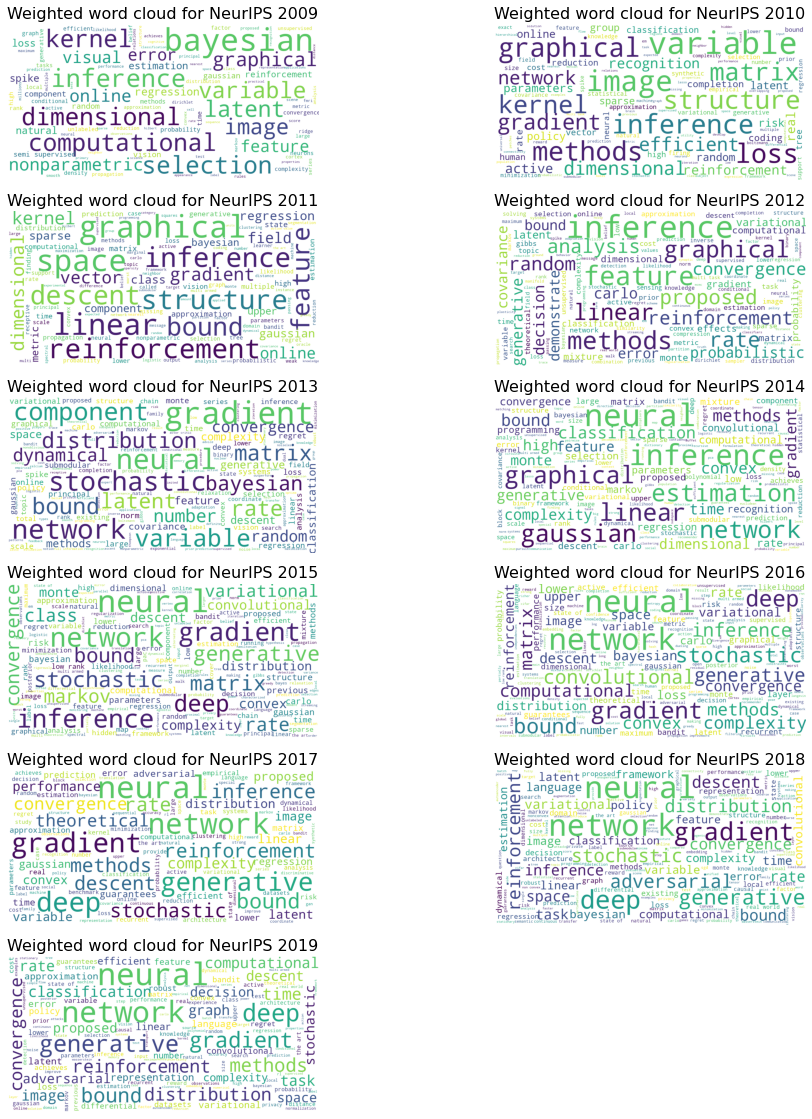

In [15]:
from random import shuffle

import matplotlib.pyplot as plt
from wordcloud import WordCloud


fig = plt.figure()
for idx, year in enumerate(range(2009, 2020)):
    wc_keywords = []
    for k, v in keywords_year_counter_n2[year].items():
        if '_' in k  and v > 1:
            for _ in range(0, v):
                for w in k.split('_'):
                    term_stem = main_stem_mapping.get(w.strip(), w.strip()) 
                    if term_stem not in skip_words:
                        wc_keywords.append(term_stem)
    ax = fig.add_subplot(6, 2, idx + 1)
    ax.set_title(f'Weighted word cloud for NeurIPS {year}', fontsize=16)
    fig.set_figheight(20)
    fig.set_figwidth(16)
    shuffle(wc_keywords)
    word_cloud = WordCloud(
        background_color='white', max_words=200, max_font_size=40, scale=3,
        random_state=42).generate(' '.join(wc_keywords))
    ax.imshow(word_cloud)
    ax.axis('off')
plt.show()